In [25]:
## Basic Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import joblib  
%matplotlib inline

In [2]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [3]:
## Import data from Kaggle

# Set the Kaggle config directory to the folder containing your kaggle.json file
os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/Ifelo/.kaggle'

# Continue with Kaggle API calls
import kaggle

# Replace 'dataset-name' and 'owner-name' with your desired dataset and owner's username.
kaggle.api.dataset_download_files('adrianmcmahon/imdb-india-movies', path='./', unzip=True)

In [4]:
# List files in the current directory to confirm the downloaded dataset
files_in_directory = os.listdir('.')
print(files_in_directory)

['.ipynb_checkpoints', 'app.py', 'IMDb Movies India.csv', 'imdb-india-movies.zip', 'knn_model.pkl', 'Movie Rating Prediction.ipynb', 'Titanic Survival Prediction.ipynb', 'Titanic-Dataset.csv']


In [5]:
# Load a CSV file from the downloaded dataset

# Load a CSV file from the downloaded dataset with 'ISO-8859-1' encoding
df = pd.read_csv('IMDb Movies India.csv', encoding='ISO-8859-1')


In [6]:
## Data Exploration
print("Shape of the dataset:", df.shape)  # Show the number of rows and columns
print("\nColumns in the dataset:", df.columns)  # Display column names
print("\nData types of columns:")
print(df.dtypes)  # Show the data types of each column
print("\nSummary statistics:")
print(df.describe())  # Show summary statistics (mean, std, min, max, etc.) for numerical columns
print("\nFirst few rows of the dataset:")
print(df.head())  # Display the first few rows of the dataset
print("\nLast few rows of the dataset:")
print(df.tail())  # Display the last few rows of the dataset
print("\nMissing values in the dataset:")
print(df.isnull().sum())  # Show the count of missing values in each column

Shape of the dataset: (15509, 10)

Columns in the dataset: Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')

Data types of columns:
Name         object
Year         object
Duration     object
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

Summary statistics:
            Rating
count  7919.000000
mean      5.841621
std       1.381777
min       1.100000
25%       4.900000
50%       6.000000
75%       6.800000
max      10.000000

First few rows of the dataset:
                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2

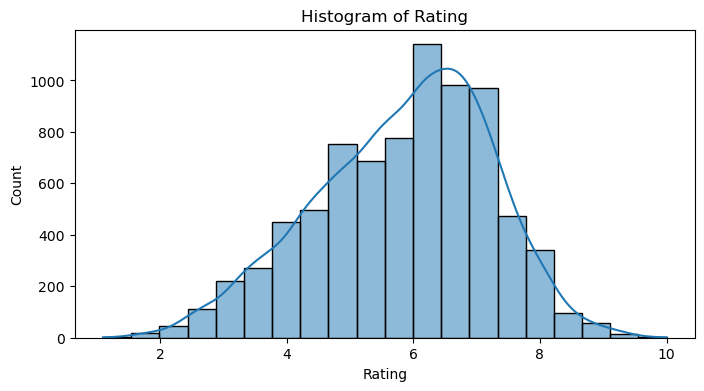

In [7]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=20)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.show()


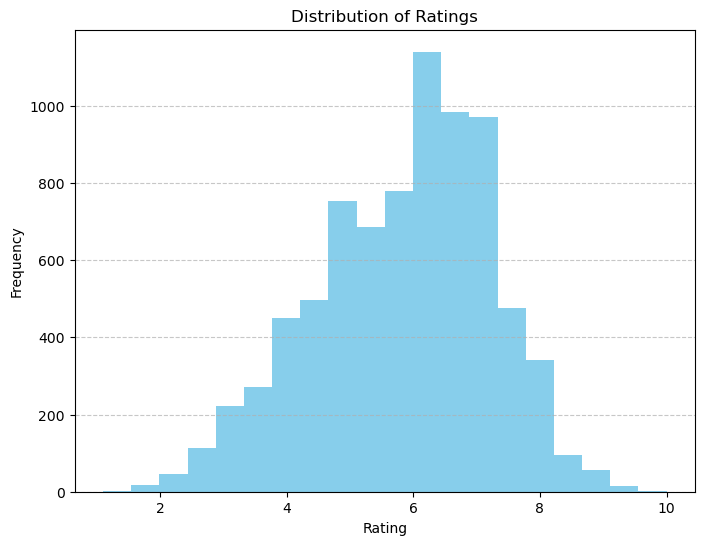

In [8]:
# Drop missing values in the 'Rating' column for visualization (if needed)
df_ratings = df['Rating'].dropna()

# Create a bar chart for the 'Rating' column
plt.figure(figsize=(8, 6))
plt.hist(df_ratings, bins=20, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [9]:
# Data Cleaning and prepocessing

# Drop the 'Name' column from the DataFrame
df.drop('Name', axis=1, inplace=True)


## Check for missing values in the 'Year' column
missing_values = df['Year'].isnull().sum()
print(f"Number of missing values in 'Year' column: {missing_values}")

# Fill missing values with a placeholder value or strategy (for example, 0 or -1)
df['Year'].fillna('0', inplace=True)  # Replace NaNs with '0' (or any other appropriate strategy)

# Remove non-numeric characters from the 'Year' column to extract the year part
df['Year'] = df['Year'].astype(str).str.extract('(\d+)').fillna('0').astype(int)

# Extracting the numeric part from 'Duration' column and converting it to integers
df['Duration'] = df['Duration'].str.extract('(\d+)').astype(float).fillna(0).astype(int)

# Fill missing values in the 'Duration' column with a placeholder value (e.g., 0)
df['Duration'].fillna(0, inplace=True)

# Convert 'Duration' column to integers after handling missing values
df['Duration'] = df['Duration'].astype(int)

# Split the 'Genre' column into binary variables using one-hot encoding
genres = df['Genre'].str.get_dummies(', ')
df = pd.concat([df, genres], axis=1)
df.drop('Genre', axis=1, inplace=True)

# Encode categorical variables: 'Director', 'Actor 1', 'Actor 2', 'Actor 3'
label_encoders = {}
categorical_cols = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


Number of missing values in 'Year' column: 528


In [10]:
# Assuming 'Year' is the column with missing values in the DataFrame 'df'
df.dropna(subset=['Year'], inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         15509 non-null  int32  
 1   Duration     15509 non-null  int32  
 2   Rating       7919 non-null   float64
 3   Votes        7920 non-null   object 
 4   Director     15509 non-null  int32  
 5   Actor 1      15509 non-null  int32  
 6   Actor 2      15509 non-null  int32  
 7   Actor 3      15509 non-null  int32  
 8   Action       15509 non-null  int64  
 9   Adventure    15509 non-null  int64  
 10  Animation    15509 non-null  int64  
 11  Biography    15509 non-null  int64  
 12  Comedy       15509 non-null  int64  
 13  Crime        15509 non-null  int64  
 14  Documentary  15509 non-null  int64  
 15  Drama        15509 non-null  int64  
 16  Family       15509 non-null  int64  
 17  Fantasy      15509 non-null  int64  
 18  History      15509 non-null  int64  
 19  Horr

In [12]:
# Define feature and target variable
X = df.drop(['Rating', 'Votes'], axis=1)
y = df['Rating']

In [13]:
# Printing feature variable 'X'
print(X)

# Printing target variable 'Y'
print(y)


       Year  Duration  Director  Actor 1  Actor 2  Actor 3  Action  Adventure  \
0         0         0      1926     2250      800     3108       0          0   
1      2019       109      1548     3280     4790      527       0          0   
2      2021        90      5123     3713     2866     3450       0          0   
3      2019       110      3319     2917     1504     4020       0          0   
4      2010       105       385     3112     3462      405       0          0   
...     ...       ...       ...      ...      ...      ...     ...        ...   
15504  1988         0      2690     2586     4299     4262       1          0   
15505  1999       129      2499      227     4532      519       1          0   
15506  2005         0      2424     3609     4891     4820       1          0   
15507  1988         0      5938     4718     4891     4820       1          0   
15508  1998       130      2195     1139     1589      490       1          0   

       Animation  Biography

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (12407, 30)
Shape of y_train: (12407,)


In [16]:
# Check for NaN or infinite values
print(X_train.isnull().sum())
print(X_train.isin([np.nan, np.inf, -np.inf]).sum())

Year           0
Duration       0
Director       0
Actor 1        0
Actor 2        0
Actor 3        0
Action         0
Adventure      0
Animation      0
Biography      0
Comedy         0
Crime          0
Documentary    0
Drama          0
Family         0
Fantasy        0
History        0
Horror         0
Music          0
Musical        0
Mystery        0
News           0
Reality-TV     0
Romance        0
Sci-Fi         0
Short          0
Sport          0
Thriller       0
War            0
Western        0
dtype: int64
Year           0
Duration       0
Director       0
Actor 1        0
Actor 2        0
Actor 3        0
Action         0
Adventure      0
Animation      0
Biography      0
Comedy         0
Crime          0
Documentary    0
Drama          0
Family         0
Fantasy        0
History        0
Horror         0
Music          0
Musical        0
Mystery        0
News           0
Reality-TV     0
Romance        0
Sci-Fi         0
Short          0
Sport          0
Thriller       0
W

In [17]:
# Check for NaN or infinite values
print(y_train.isnull().sum())
print(y_train.isin([np.nan, np.inf, -np.inf]).sum())

6047
6047


In [18]:
# Calculate mean of non-NaN values in y_train
mean_y_train = y_train[~y_train.isnull()].mean()

# Replace NaN values in y_train with the mean
y_train.fillna(mean_y_train, inplace=True)

In [19]:
# Model
# Models and their respective hyperparameters for tuning
models = [
    {
        'model': RandomForestRegressor(random_state=42),
        'param_dist': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    {
        'model': GradientBoostingRegressor(random_state=42),
        'param_dist': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    },
    {
        'model': DecisionTreeRegressor(random_state=42),
        'param_dist': {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
]

# Hyperparameter tuning using RandomizedSearchCV for each model
for model_info in models:
    model = model_info['model']
    param_dist = model_info['param_dist']
    
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    
    print(f"Best parameters for {model.__class__.__name__}:")
    print(random_search.best_params_)
    

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for RandomForestRegressor:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for GradientBoostingRegressor:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.1}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for DecisionTreeRegressor:
{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
